## Import all required libraries

In [2]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import *

%matplotlib inline

<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In [2]:
def plotvars(scenario):
    # CO2 Emission
    emiss = scenario.var("EMISS")
    emiss = emiss.loc[(emiss['type_tec'] == 'all') & 
                      (emiss['node'] == 'World') & 
                      (emiss['emission'] == 'TCE')]
    emiss_plot = emiss[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Removal
    removal = scenario.var("EMISS")
    removal = removal.loc[(removal['type_tec'] == 'all') & 
                          (removal['node'] == 'World') & 
                          (removal['emission'] == 'CO2_storage')]
    removal_plot = removal[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Prices
    CO2Price = (scenario.var("PRICE_EMISSION")
                .loc[scenario.var("PRICE_EMISSION")['type_emission'] == 'TCE'][['year','lvl']]
                .set_index(['year'])).div(1000)
    
    
    plt.figure(figsize=(4,4))
    # Plottings
    plt.plot(emiss_plot, label='CO2 Emission')
    plt.plot(removal_plot, label='CO2 Removal')
    plt.plot(CO2Price, label='CO2 Price')
    
    plt.ylim(-10,40)
    plt.ylabel("thousands of var unit")
    
    plt.legend()
    plt.show()

In [49]:
# SSPs and scenarios lists
ssps = ["SSP1","SSP2","SSP3","SSP4","SSP5"]
#ssps = ["SSP1"]
# Parameters for CO2 injection rate scenarios
co2rates = {
    "co2rate1": 0.2,
#    "co2rate2": 0.4,
#    "co2rate3": 0.6,
#    "co2rate4": 0.8,
    "co2rate5": 1.0,
        }
max_rate = 20000

# Parameters for DAC market penetration rate scenarios
mpens = {
    "mpen1": 0.050,
#    "mpen2": 0.075,
#    "mpen3": 0.100,
#    "mpen4": 0.125,
    "mpen5": 0.150,
        }

# Parameters for CO2 storage availability scenarios
stors = {
    "stor1": 0.2,
#    "stor2": 0.4,
#    "stor3": 0.6,
#    "stor4": 0.8,
    "stor5": 1.0,
        }

fco2storshares = {
    "fco2storshare1": 1.00, # max
#    "fco2storshare2": 0.75, # max
#    "fco2storshare3": 0.50, # max
#    "fco2storshare4": 0.50, # min
    "fco2storshare5": 0.75, # min
}

## Create baseline and emission bound scenarios with split CO2 infrastructure

-------- SSP1 runs --------
DAC baseline|Old setup CO2 infrastructure


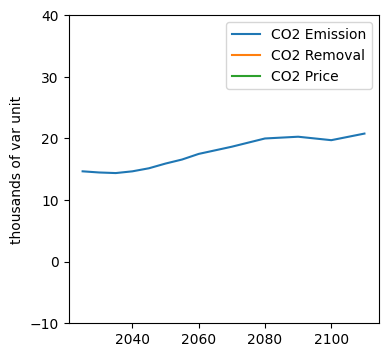

DAC baseline|Split CO2 infrastructure


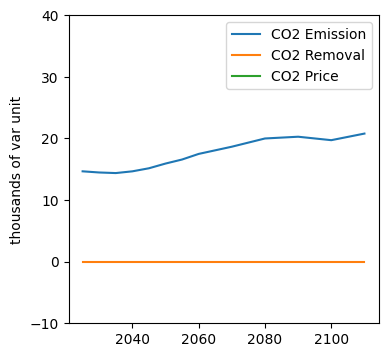

DAC 1000f|Split CO2 infrastructure


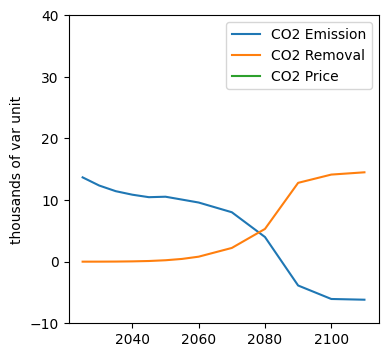

-------- SSP5 runs --------
DAC baseline|Old setup CO2 infrastructure


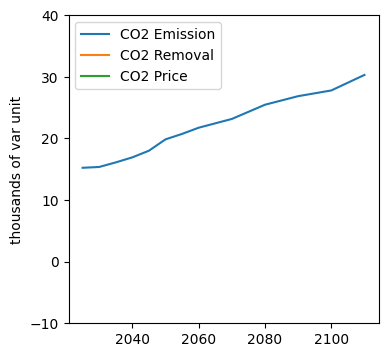

DAC baseline|Split CO2 infrastructure


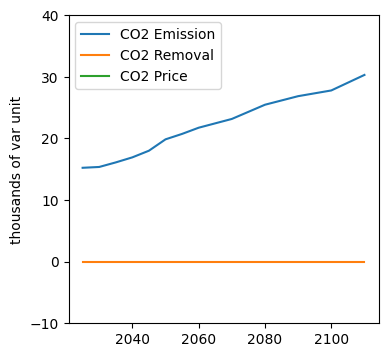

DAC 1000f|Split CO2 infrastructure


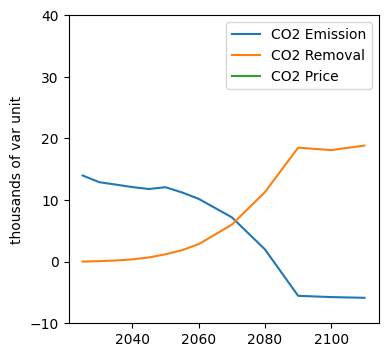

In [4]:
# CONNECT TO DATABASE
mp = ixmp.Platform()
    
for ssp in ssps:
    print(f"-------- {ssp} runs --------")
    # CLONE OLD BASELINE SCENARIO & CREATE DAC BASELINE SCENARIO
    base = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v0.1', scenario="baseline_v0.13")
    base_scen = base.clone(
        f"SSP_dev_{ssp}_v0.1_dac",
        "baseline_v0.13",
        f"{ssp}_dev for DAC",
        keep_solution=False, 
    )
    base_scen.check_out()

    year_df = base_scen.vintage_and_active_years()
    vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
    model_horizon = base_scen.set("year")

    base_scen.commit(comment=f"{ssp}_dev DAC baseline with old CCS infrastructure setup")
    base_scen.set_as_default()

    base_scen.solve(solve_options={'scaind': '1'})
    
    print("DAC baseline|Old setup CO2 infrastructure")
    plotvars(base_scen)
    
    
    
    
    
    # CREATE DAC BASELINE WITH SPLIT CO2 TRANSMISSION AND DISPOSAL INFRASTRUCTURE
    scen = base_scen.clone(
        f"SSP_dev_{ssp}_v0.1_dac",
        "baseline_v0.13_dac-co2split",
        "dac baseline with split CO2 transmission and disposal",
        keep_solution=False, 
    )
    scen.check_out()

    year_df = scen.vintage_and_active_years()
    vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
    model_horizon = scen.set("year")
    
    #- REMOVE OLD SETUP
    ## remove relations
    ### list of parameters to remove
    params = ['relation_activity']

    ### list of technologies to remove
    techs = ['co2_tr_dis', 'bco2_tr_dis',
             'bio_istig_ccs','bio_ppl_co2scr','eth_bio_ccs','h2_bio_ccs','liq_bio_ccs',
             'c_ppl_co2scr','cement_co2scr','coal_adv_ccs','g_ppl_co2scr','gas_cc_ccs',
             'h2_coal_ccs','h2_smr_ccs','igcc_ccs','meth_coal_ccs','meth_ng_ccs','syn_liq_ccs']
    rels = ['co2_trans_disp','bco2_trans_disp','CO2_Emission_Global_Total', 'CO2_Emission',]

    ### removing parameters
    for par in params:
        scen.remove_par(par, scen.par(par,{'technology':techs,'relation':rels}))

    ## remove pipelines
    ### list of parameters to remove
    params = ['inv_cost','fix_cost','input','capacity_factor','technical_lifetime',
              'construction_time','abs_cost_activity_soft_up','growth_activity_lo',
              'level_cost_activity_soft_lo','level_cost_activity_soft_up','relation_activity',
              'var_cost','output','emission_factor','soft_activity_lo','soft_activity_up',
              'growth_activity_up','initial_activity_up']

    ### list of technologies to remove
    pipes = ['co2_tr_dis', 'bco2_tr_dis']
    
    ### removing parameters
    for par in params:
        scen.remove_par(par, scen.par(par,{'technology':pipes}))

    ## remove sets    
    ### removing pipelines and relations from sets
    scen.remove_set('technology',pipes)
    scen.remove_set('relation',rels[0:2])
    
    #- ADD NEW SETUP
    ## add CO2_storage
    scen.add_set('emission',"CO2_storage")

    ## setup pipelines and storage technologies
    ### add technologies
    filepath = 'C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/SSPs/ssp_data/co2infrastructure_data_ssp2dev.yaml'
    add_tech(scen,filepath=filepath)
    
    ### removing some pipelines and storage parameters
    newpipesnstors = ['co2_stor','co2_tr_ld', 'co2_tr_sd']
    pars2remove = ['var_cost','input','output','emission_factor','capacity_factor']
    for par in pars2remove:
        df = scen.par(par,{'technology':newpipesnstors})
        df= df.loc[df['year_vtg'] != df['year_act']]
        scen.remove_par(par, df)

    ### removing excess year_act
    pars2remove = ['output']
    for par in pars2remove:
        df = scen.par(par,{'technology':techs})
        df = df.loc[df['year_act'] > df['year_vtg'].add(30)]
        scen.remove_par(par, df)
    
    ## setup dac technologies
    ### adding dac
    filepath = 'C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/SSPs/ssp_data/daccs_setup_data_ssp2dev.yaml'
    add_tech(scen,filepath=filepath)
    
    ### removing some dac parameters
    newpipesnstors = ['co2_tr_sd','co2_stor']
    pars2remove = ['emission_factor','capacity_factor','var_cost','input','output']
    for par in pars2remove:
        df = scen.par(par,{'technology':newpipesnstors})
        df= df.loc[df['year_vtg'] != df['year_act']]
        scen.remove_par(par, df)

    ### removing excess year_act
    pars2remove = ['capacity_factor','fix_cost','input','output']
    techs = ['dac_lt', 'dac_ht']
    for par in pars2remove:
        df = scen.par(par,{'technology':techs})
        df = df.loc[df['year_act'] > df['year_vtg'].add(30)]
        scen.remove_par(par, df)

    ### adding relation_upper and _lower for market penetration limit
    nodes = [node for node in scen.set("node") if node != "World"]
    rels = ["DAC_mpen_c"]
    df_list = []
    for rel in rels:
        for node in nodes:
            df = make_df("relation_upper",
                         relation=rel,
                         node_rel=node,
                         year_rel=list(sorted(set(act_years))),
                         unit = "-",
                         value = 0
                        )
            df_list = df_list + [df]
    dfpar2add = pd.concat(df_list)
    scen.add_par("relation_upper", dfpar2add)
    scen.add_par("relation_lower", dfpar2add)
    
    scen.commit(comment=f"{ssp} baseline scenario with dac and split CO2 infrastructure")
    scen.set_as_default()
    
    scen.solve(solve_options={'barcrossalg': '2','scaind':'0'}) # solve_options={'barcrossalg': '2','scaind':'1'}
    # scen.var("OBJ")["lvl"]
    
    print("DAC baseline|Split CO2 infrastructure")
    plotvars(scen)
    
    
    
    
    
    
    # CREATE 1000f SCENARIO
    co2bound_scen = scen.clone(
        f"SSP_dev_{ssp}_v0.1_dac",
        "1000f_v0.13_dac-co2split",
        "dac 1000f carbon budget with split CO2 transmission and disposal",
        keep_solution=False, 
    )
    co2bound_scen.check_out()

    ## add emission bound
    co2bound_scen.add_par('bound_emission', ['World', 'TCE', 'all', 'cumulative'], value=4046, unit="tC")
    
    ## run and report scenario
    co2bound_scen.commit(comment=f"{ssp}_dev 1000f without DAC scenario")
    co2bound_scen.set_as_default()

    co2bound_scen.solve(solve_options={'scaind': '1'}) # solve_options={'barcrossalg': '2','scaind':'1'}
    co2bound_scen.var("OBJ")["lvl"]
    
    print("DAC 1000f|Split CO2 infrastructure")
    plotvars(co2bound_scen)
    
    

# CLOSE CONNECTION
mp.close_db()

# Run market penetration `mpen` scenarios

mpen scenario: SSP1 mpen1


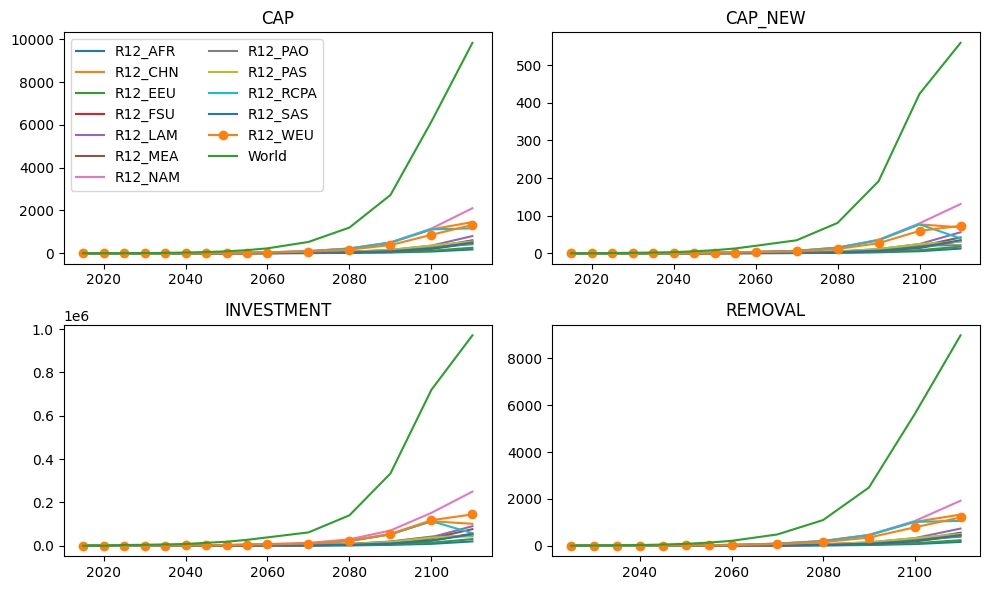

mpen scenario: SSP1 mpen5


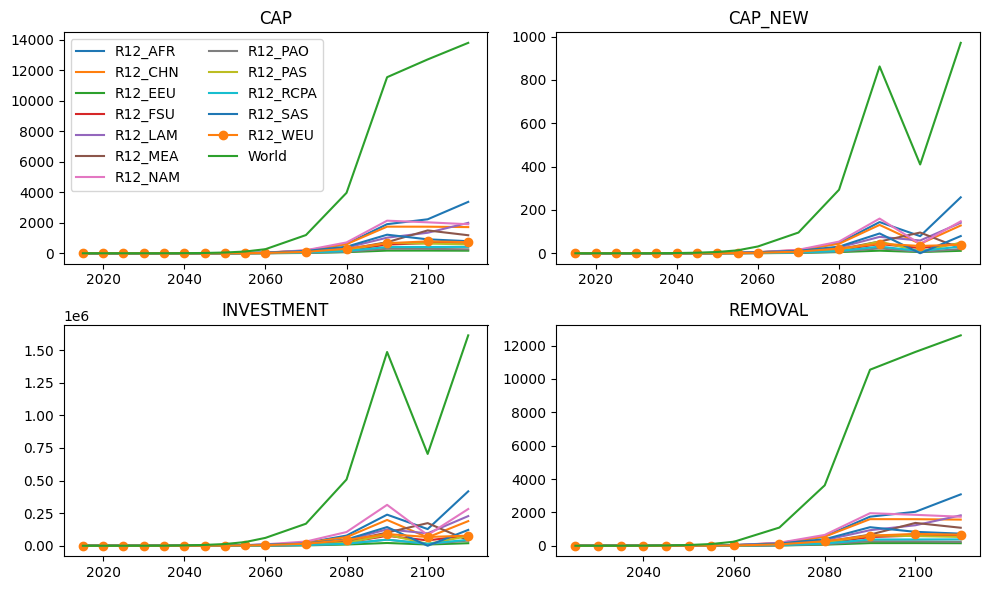

mpen scenario: SSP2 mpen1
mpen scenario: SSP2 mpen5
mpen scenario: SSP3 mpen1
mpen scenario: SSP3 mpen5
mpen scenario: SSP4 mpen1
mpen scenario: SSP4 mpen5
mpen scenario: SSP5 mpen1
mpen scenario: SSP5 mpen5


In [50]:
# CONNECT TO DATABASE
mp = ixmp.Platform()

# this is to import scenario from data base and clone to local
for ssp in ssps:
    for key,val in mpens.items():
        dacsspscen = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v0.1_dac', scenario="1000f_v0.13_dac-co2split")
        dacmp_scen = dacsspscen.clone(
            f"SSP_dev_{ssp}_v0.1_dac",
            f"1000f_v0.13_dac-co2split_{key}",
            f"{ssp}_dev 1000f carbon budget with {key} dac and split CO2 transmission and disposal",
            keep_solution=False, 
        )
        dacmp_scen.check_out()

        # Updating market penetration rates
        DAC_mpen_rem = dacmp_scen.par("growth_activity_up", {"technology":"DAC_mpen"})
        DAC_mpen_add = DAC_mpen_rem.copy()
        DAC_mpen_add["value"] = val

        dacmp_scen.remove_par("growth_activity_up", DAC_mpen_rem)
        dacmp_scen.add_par("growth_activity_up", DAC_mpen_add)

        # add emission bound
        dacmp_scen.commit(comment=f"{ssp}_dev 1000f with DAC {key} scenario")
        dacmp_scen.set_as_default()

        dacmp_scen.solve(solve_options={'scaind': '1'})
        dacmp_scen.var("OBJ")["lvl"]

        # Get Report
        print("mpen scenario:", ssp, key)
        if ssp == "SSP1":
            scenariotec = ['dac_lt','dac_ht']
            scenario_report = get_report(dacmp_scen,scenariotec)

# CLOSE CONNECTION
mp.close_db()

# Run CO$_2$ storage scenarios

stor scenario: SSP1 stor1


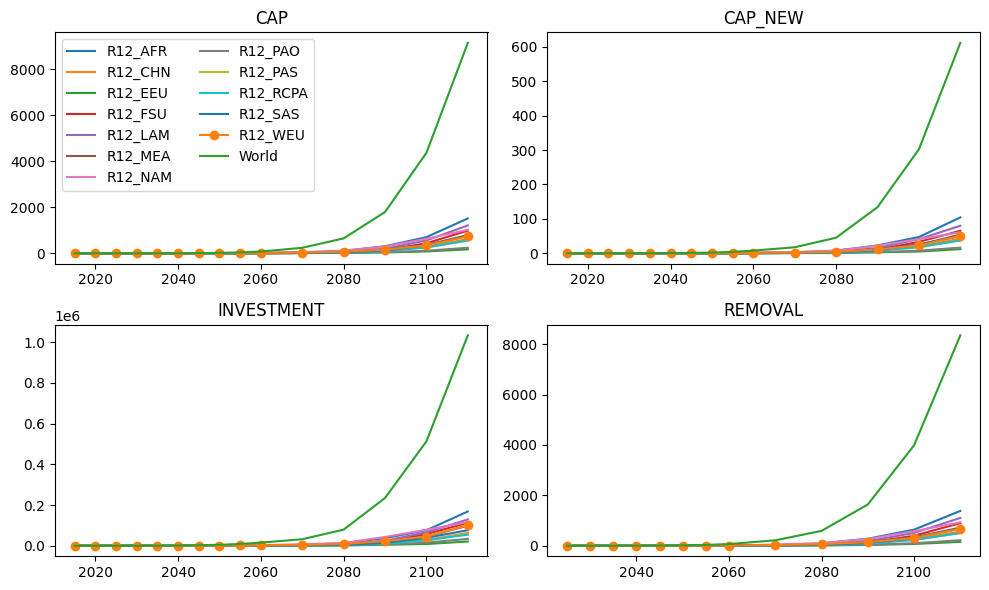

stor scenario: SSP1 stor5


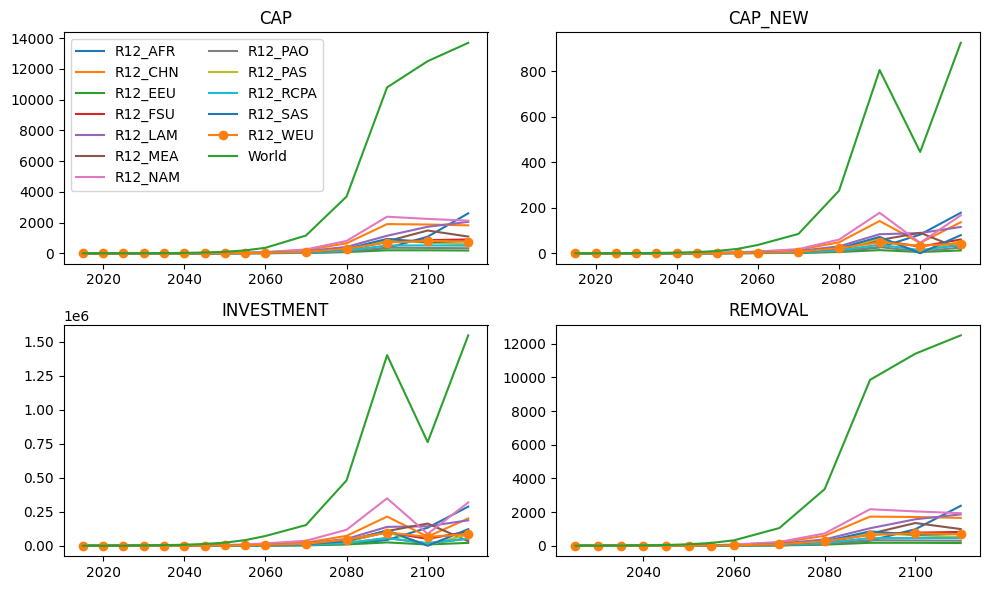

stor scenario: SSP2 stor1
stor scenario: SSP2 stor5
stor scenario: SSP3 stor1
stor scenario: SSP3 stor5
stor scenario: SSP4 stor1
stor scenario: SSP4 stor5
stor scenario: SSP5 stor1
stor scenario: SSP5 stor5


In [51]:
# CONNECT TO DATABASE
mp = ixmp.Platform()

storbase = message_ix.Scenario(mp, model=f'SSP_dev_SSP5_v0.1_dac', scenario="1000f_v0.13_dac-co2split_mpen5")

nodes = [node for node in storbase.set("node")]
len_periods = [5,5,5,5,5,5,5,5,10,10,10,10,10]

# Annual CO2 stored
co2_stored = storbase.var("EMISS",
    {"emission":"CO2_storage",
    "node":[node for node in nodes if node not in ["World","R12_GLB"]],
    "type_tec":"all"}).set_index(["node","year"])["lvl"].unstack().mul(len_periods,axis=1)

# Calculate storage volume requirements and constraint's value
co2stor_req = co2_stored.cumsum(axis=1)[[2110]].rename(columns={2110:"StorV"}) # storage volume
co2stor_con = np.round(co2stor_req.div(90).rename(columns={"StorV":"bound_emission"}),0) # values in cumulative bound_emission

# this is to import scenario from data base and clone to local
for ssp in ssps:
    for key,val in stors.items():
        dacsspscen = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v0.1_dac', scenario="1000f_v0.13_dac-co2split")
        dacstor_scen = dacsspscen.clone(
            f"SSP_dev_{ssp}_v0.1_dac",
            f"1000f_v0.13_dac-co2split_mpen3_{key}",
            f"{ssp}_dev 1000f carbon budget with mpen3 dac, {key} storage, and split CO2 transmission and disposal",
            keep_solution=False, 
        )
        dacstor_scen.check_out()
        
        # adding set up for limiting storage volume
        if "CO2_storage" not in dacstor_scen.set("emission"):
            dacstor_scen.add_set("emission", "CO2_storage")
        if "co2_stor_pot" not in dacstor_scen.set("type_emission"):
            dacstor_scen.add_set("type_emission", "co2_storage_pot")
        if "co2_potential" not in dacstor_scen.set("type_tec"):
            dacstor_scen.add_set("type_tec", "co2_potential")
        if "co2_stor" not in dacstor_scen.set("technology"):
            dacstor_scen.add_set("technology", "co2_stor")

        dacstor_scen.add_set("cat_emission", ["co2_storage_pot", "CO2_storage"])
        dacstor_scen.add_set("cat_tec", ["co2_potential", "co2_stor"])
        
        # Updating storage volume limits
        nodes = [node for node in nodes if node not in ["R12_GLB","World"]]
        df_list = []
        for node in nodes:
            df = make_df("bound_emission",
                         node=node,
                         type_emission="co2_storage_pot",
                         type_tec="co2_potential",
                         type_year="cumulative",
                         value = co2stor_con.loc[node,"bound_emission"],
                         unit = "???",
                        )
            df_list = df_list + [df]
        df_stor = pd.concat(df_list)
        df_stor["value"] = df_stor["value"].mul(val) # ultimate potential x fraction
        
        dacstor_scen.add_par("bound_emission", df_stor)

        # add emission bound
        dacstor_scen.commit(comment=f"{ssp}_dev 1000f with DAC {key} scenario")
        dacstor_scen.set_as_default()

        dacstor_scen.solve(solve_options={'scaind': '1'})
        dacstor_scen.var("OBJ")["lvl"]

        # Get Report
        print("stor scenario:", ssp, key)
        if ssp == "SSP1":
            scenariotec = ['dac_lt','dac_ht']
            scenario_report = get_report(dacstor_scen,scenariotec)

# CLOSE CONNECTION
mp.close_db()

# Run CO$_2$ injection rates scenarios

stor scenario: SSP1 co2rate1


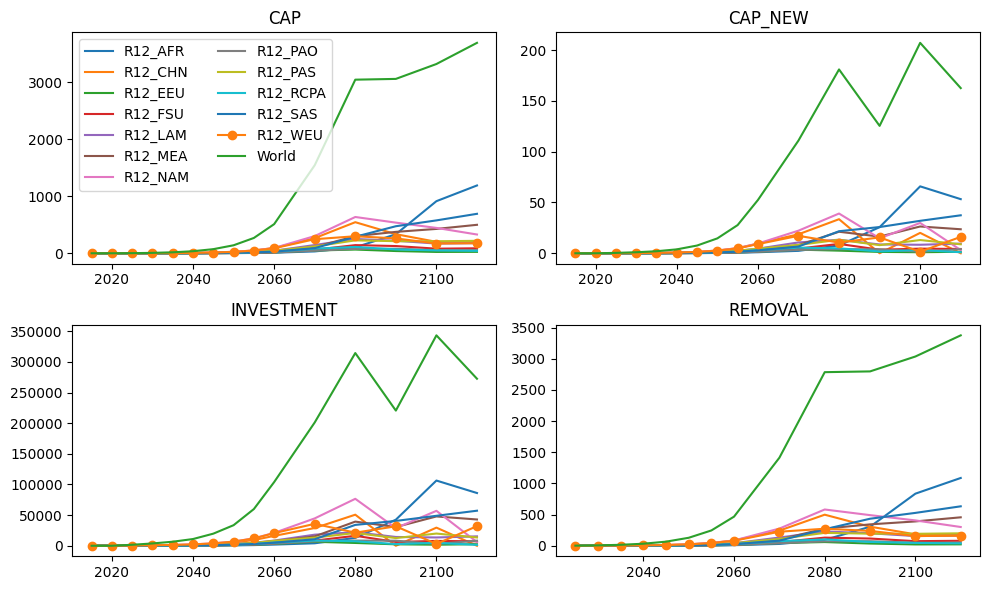

stor scenario: SSP1 co2rate5


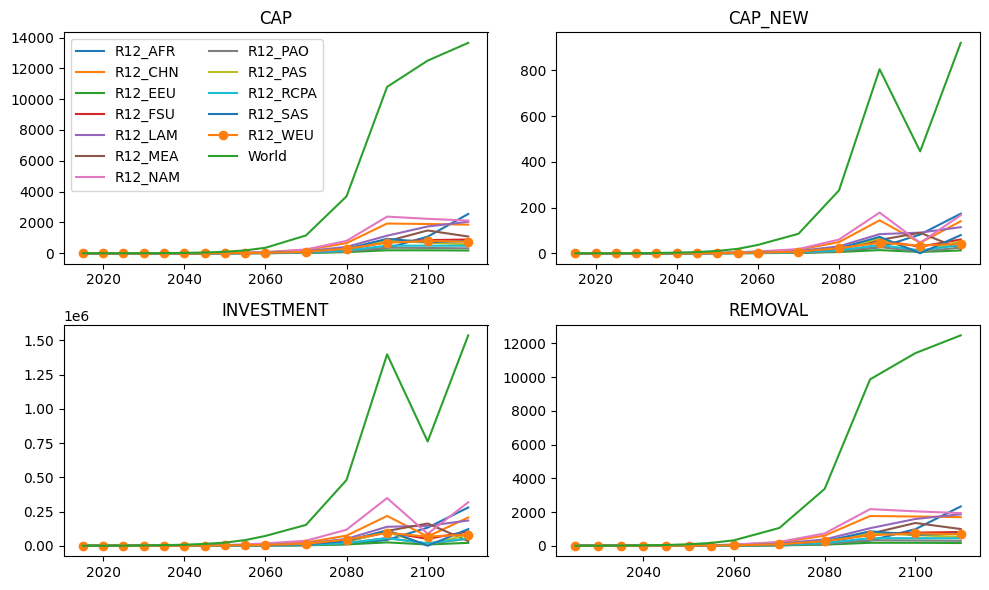

stor scenario: SSP2 co2rate1
stor scenario: SSP2 co2rate5
stor scenario: SSP3 co2rate1
stor scenario: SSP3 co2rate5
stor scenario: SSP4 co2rate1
stor scenario: SSP4 co2rate5
stor scenario: SSP5 co2rate1
stor scenario: SSP5 co2rate5


In [52]:
# CONNECT TO DATABASE
mp = ixmp.Platform()

storbase = message_ix.Scenario(mp, model=f'SSP_dev_SSP5_v0.1_dac', scenario="1000f_v0.13_dac-co2split_mpen5")
nodes = [node for node in storbase.set("node")]
years = list(sorted(set(storbase.vintage_and_active_years()["year_act"])))

# Annual CO2 stored
co2_stored = storbase.var("EMISS",
    {"emission":"CO2_storage",
    "node":[node for node in nodes if node not in ["World","R12_GLB"]],
    "type_tec":"all"}).set_index(["node","year"])["lvl"].unstack()

# this is to import scenario from data base and clone to local
for ssp in ssps:
    for key,val in co2rates.items():
        dacsspscen = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v0.1_dac', scenario="1000f_v0.13_dac-co2split")
        dacrate_scen = dacsspscen.clone(
            f"SSP_dev_{ssp}_v0.1_dac",
            f"1000f_v0.13_dac-co2split_mpen3_{key}",
            f"{ssp}_dev 1000f carbon budget with mpen3 dac, {key} co2 rate, and split CO2 transmission and disposal",
            keep_solution=False, 
        )
        dacrate_scen.check_out()
        
        # adding set up for limiting storage volume
        if "CO2_storage" not in dacrate_scen.set("emission"):
            dacrate_scen.add_set("emission", "CO2_storage")
        if "co2_stor_pot" not in dacrate_scen.set("type_emission"):
            dacrate_scen.add_set("type_emission", "co2_storage_pot")
        if "co2_potential" not in dacrate_scen.set("type_tec"):
            dacrate_scen.add_set("type_tec", "co2_potential")
        if "co2_stor" not in dacrate_scen.set("technology"):
            dacrate_scen.add_set("technology", "co2_stor")

        dacrate_scen.add_set("cat_emission", ["co2_storage_pot", "CO2_storage"])
        dacrate_scen.add_set("cat_tec", ["co2_potential", "co2_stor"])
        
        # Updating storage volume limits
        
        df_list = []
        for year in years:
            df = make_df("bound_emission",
                         node="World",
                         type_emission="co2_storage_pot",
                         type_tec="co2_potential",
                         type_year=year,
                         value = (max_rate * val), # ultimate rate x fraction
                         unit = "???",
                        )
            df_list += [df]
        df_co2ratelim = pd.concat(df_list)
        
        dacrate_scen.add_par("bound_emission", df_co2ratelim)

        # add emission bound
        dacrate_scen.commit(comment=f"{ssp}_dev 1000f with DAC {key} scenario")
        dacrate_scen.set_as_default()

        dacrate_scen.solve(solve_options={'scaind': '1'})
        dacrate_scen.var("OBJ")["lvl"]

        # Get Report
        print("stor scenario:", ssp, key)
        if ssp == "SSP1":
            scenariotec = ['dac_lt','dac_ht']
            scenario_report = get_report(dacrate_scen,scenariotec)
            
# CLOSE CONNECTION
mp.close_db()

# Run fossil CO$_2$ storage share scenarios

stor scenario: SSP1 fco2storshare1


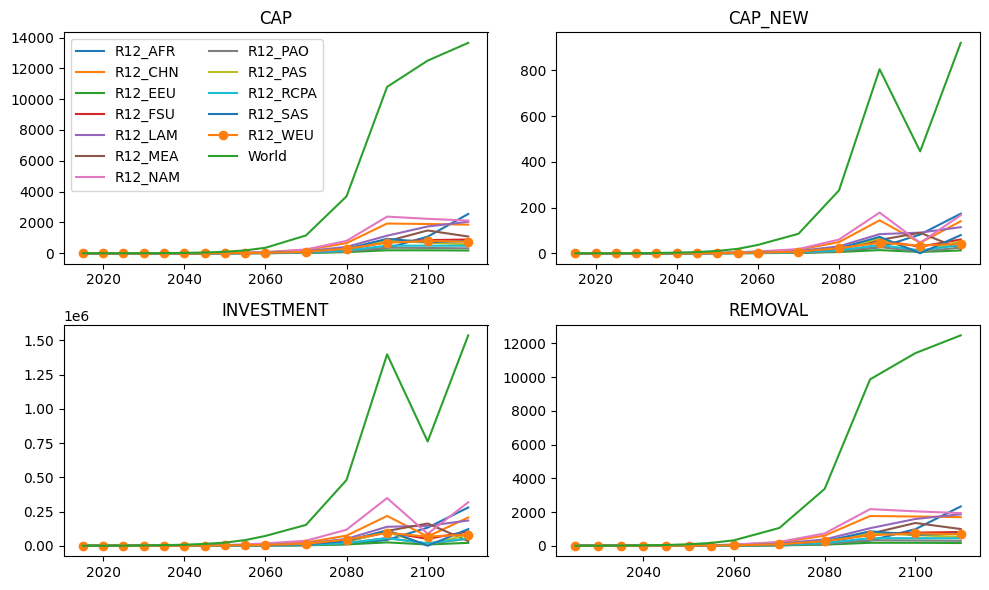

stor scenario: SSP1 fco2storshare5


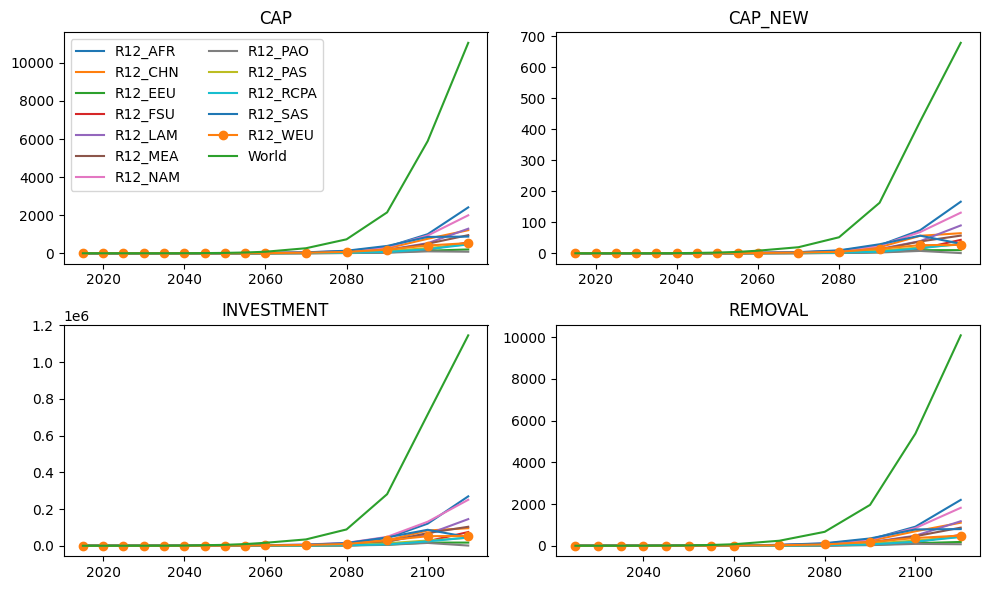

stor scenario: SSP2 fco2storshare1
stor scenario: SSP2 fco2storshare5
stor scenario: SSP3 fco2storshare1
stor scenario: SSP3 fco2storshare5
stor scenario: SSP4 fco2storshare1
stor scenario: SSP4 fco2storshare5
stor scenario: SSP5 fco2storshare1
stor scenario: SSP5 fco2storshare5


In [53]:
# CONNECT TO DATABASE
mp = ixmp.Platform()

storbase = message_ix.Scenario(mp, model=f'SSP_dev_SSP5_v0.1_dac', scenario="1000f_v0.13_dac-co2split_mpen5")

nodes = [node for node in storbase.set("node") if node not in ["World","R12_GLB"]]
years = list(sorted(set(storbase.vintage_and_active_years()["year_act"])))
len_periods = {2025:5,
               2030:5,
               2035:5,
               2040:5,
               2045:5,
               2050:5,
               2055:5,
               2060:5,
               2070:10,
               2080:10,
               2090:10,
               2100:10,
               2110:10}
modes = ["M1","M2","M3"]

# this is to import scenario from data base and clone to local
for ssp in ssps:
    for key,val in fco2storshares.items():
        dacsspscen = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v0.1_dac', scenario="1000f_v0.13_dac-co2split")
        dacstor_scen = dacsspscen.clone(
            f"SSP_dev_{ssp}_v0.1_dac",
            f"1000f_v0.13_dac-co2split_mpen3_{key}",
            f"{ssp}_dev 1000f carbon budget with mpen3 dac, {key} storage, and split CO2 transmission and disposal",
            keep_solution=False, 
        )
        dacstor_scen.check_out()
        
        # SETUP TECHNOLOGY AND RELATIONS TO TRACK CUMULATIVE STORAGE
        ## adding set and dummy technologies
        dacstor_scen.add_set("technology","co2_storcumulative")
        for mode in modes:
            dacstor_scen.add_set("relation",f"co2_storcum_{mode}")
        
        
        ## create relation activity
        list_relation = []
        for node in nodes:
            for mode in modes:
                for yr in years:
                    ya = [y for y in years if y <= yr]
                    relact_co2stor = make_df("relation_activity",
                                relation=f"co2_storcum_{mode}",
                                node_rel=node,
                                year_rel=yr,
                                node_loc=node,
                                technology="co2_stor",
                                year_act=ya,
                                mode=mode,
                                value= [-1 * len_periods[y] for y in ya],
                                unit = "-"
                           )

                    relact_co2storcumulative = make_df("relation_activity",
                                relation=f"co2_storcum_{mode}",
                                node_rel=node,
                                year_rel=yr,
                                node_loc=node,
                                technology="co2_storcumulative",
                                year_act=yr,
                                mode=mode,
                                value=1,
                                unit = "-"
                           )
                    list_relation += [relact_co2stor, relact_co2storcumulative]
        df_relation = pd.concat(list_relation)

        ## create relation bounds
        list_rel_eq = []
        for node in nodes:
            for mode in modes:
                rel_eq = make_df("relation_upper",
                        relation = f"co2_storcum_{mode}",
                        node_rel = node,
                        year_rel = years,
                        value = 0,
                        unit = "-"
                       )
                list_rel_eq += [rel_eq]
        df_rel_eq = pd.concat(list_rel_eq)

        ## adding parameters
        dacstor_scen.add_par("relation_activity", df_relation)
        dacstor_scen.add_par("relation_upper", df_rel_eq)
        dacstor_scen.add_par("relation_lower", df_rel_eq)

        # SETUP SHARE CONSTRAINTS
        
        ## adding share constraint of cumulative activity
        dacstor_scen.add_set("shares","fco2storshare")

        ## creating lower and upper bound dataframes
        if key in ["fco2storshare1","fco2storshare2","fco2storshare3"]:
            list_mode_ups = []
            for node in nodes:
                mode_up = make_df("share_mode_up",
                    shares = "fco2storshare",
                    node_share = node,
                    technology = "co2_storcumulative",
                    mode = "M1",
                    year_act = 2100,
                    time = "year",
                    value = val,
                    unit = "-"
                )
                list_mode_ups += [mode_up]
            df_mode_ups = pd.concat(list_mode_ups)
            dacstor_scen.add_par("share_mode_up", df_mode_ups)
        
        else:
            list_mode_los = []
            for node in nodes:
                mode_lo = make_df("share_mode_lo",
                    shares = "fco2storshare",
                    node_share = node,
                    technology = "co2_storcumulative",
                    mode = "M1",
                    year_act = 2100,
                    time = "year",
                    value = val,
                    unit = "-"
                )
                list_mode_los += [mode_lo]
            df_mode_los = pd.concat(list_mode_los)
            dacstor_scen.add_par("share_mode_lo", df_mode_los)
        
        
        # Commit and prepare to run
        dacstor_scen.commit(comment=f"{ssp}_dev 1000f with DAC {key} scenario")
        dacstor_scen.set_as_default()

        dacstor_scen.solve(solve_options={'scaind': '1'})
        # dacstor_scen.var("OBJ")["lvl"]

        # Get Report
        print("stor scenario:", ssp, key)
        if ssp == "SSP1":
            scenariotec = ['dac_lt','dac_ht']
            scenario_report = get_report(dacstor_scen,scenariotec)

# CLOSE CONNECTION
mp.close_db()

# Just checking

In [54]:
# CONNECT TO DATABASE
mp = ixmp.Platform()

ssp = "SSP1"
key = "fco2storshare5"
scen2check = message_ix.Scenario(mp, model=f"SSP_dev_{ssp}_v0.1_dac", scenario=f"1000f_v0.13_dac-co2split_mpen3_{key}")


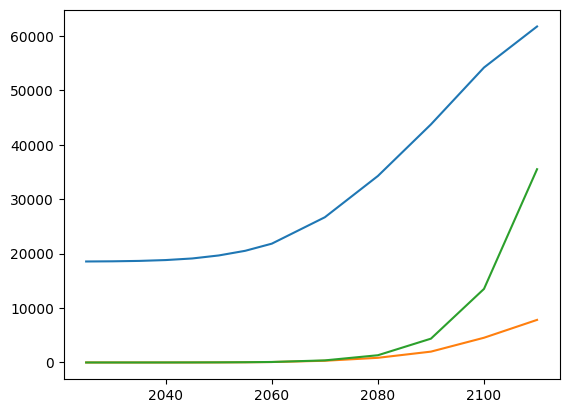

In [55]:
act = (scen2check.var("ACT", {"technology":"co2_storcumulative","node_loc":"R12_AFR"})
       .set_index(["node_loc", "technology","year_vtg","year_act","mode"])
       .groupby(level=[3,4]).sum()["lvl"].swaplevel(0,1).unstack()
      )

plt.plot(act.transpose())
plt.show()

In [56]:
# CLOSE CONNECTION
mp.close_db()